Author: Laiya Lubben (llubben@umich.edu)
<br/>Last updated: Aug 19, 2021

In [1]:
# Here is a list of libraries we need to conduct the analysis:
import pandas as pd                                           # Loading files into pandas dataframe
import numpy as np                                            # To use numpy aggregation functions
from tqdm.auto import tqdm                                    # track loop time

import pymysql                                                # connect to database
import re
import json
import model_shared_utilities as msu                          # helper functions created to create model/plots
# --------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt                               # Generate visualization 
import matplotlib.cm as cm
import altair as alt                                          
import seaborn as sns


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\laiya\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laiya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laiya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# read the secret keys from json file 
# Note the config file need to be filled with your own credentials before running this notebook 
# or ask the owners of this repository for the filled config file
with open('config.json', 'r') as f:
    secret = json.load(f)

In [3]:
# connect to the database
connection = pymysql.connect(host=secret['host'],
                              user=secret['user'],
                              password=secret['password'],
                              database=secret['database'],
                              port=secret['port'],
                              charset=secret['charset'],
                              cursorclass=pymysql.cursors.DictCursor)

cursor = connection.cursor()

cursor.execute("SELECT * FROM jd;")
table = cursor.fetchall()
connection.close()

In [4]:
# Now let's put the tables into pandas dataframe 
job_df = pd.DataFrame(table)
job_df = job_df.dropna(subset=['job_description'])

print('Job dataset has:', job_df.shape[0], 'rows of data')

Job dataset has: 18087 rows of data


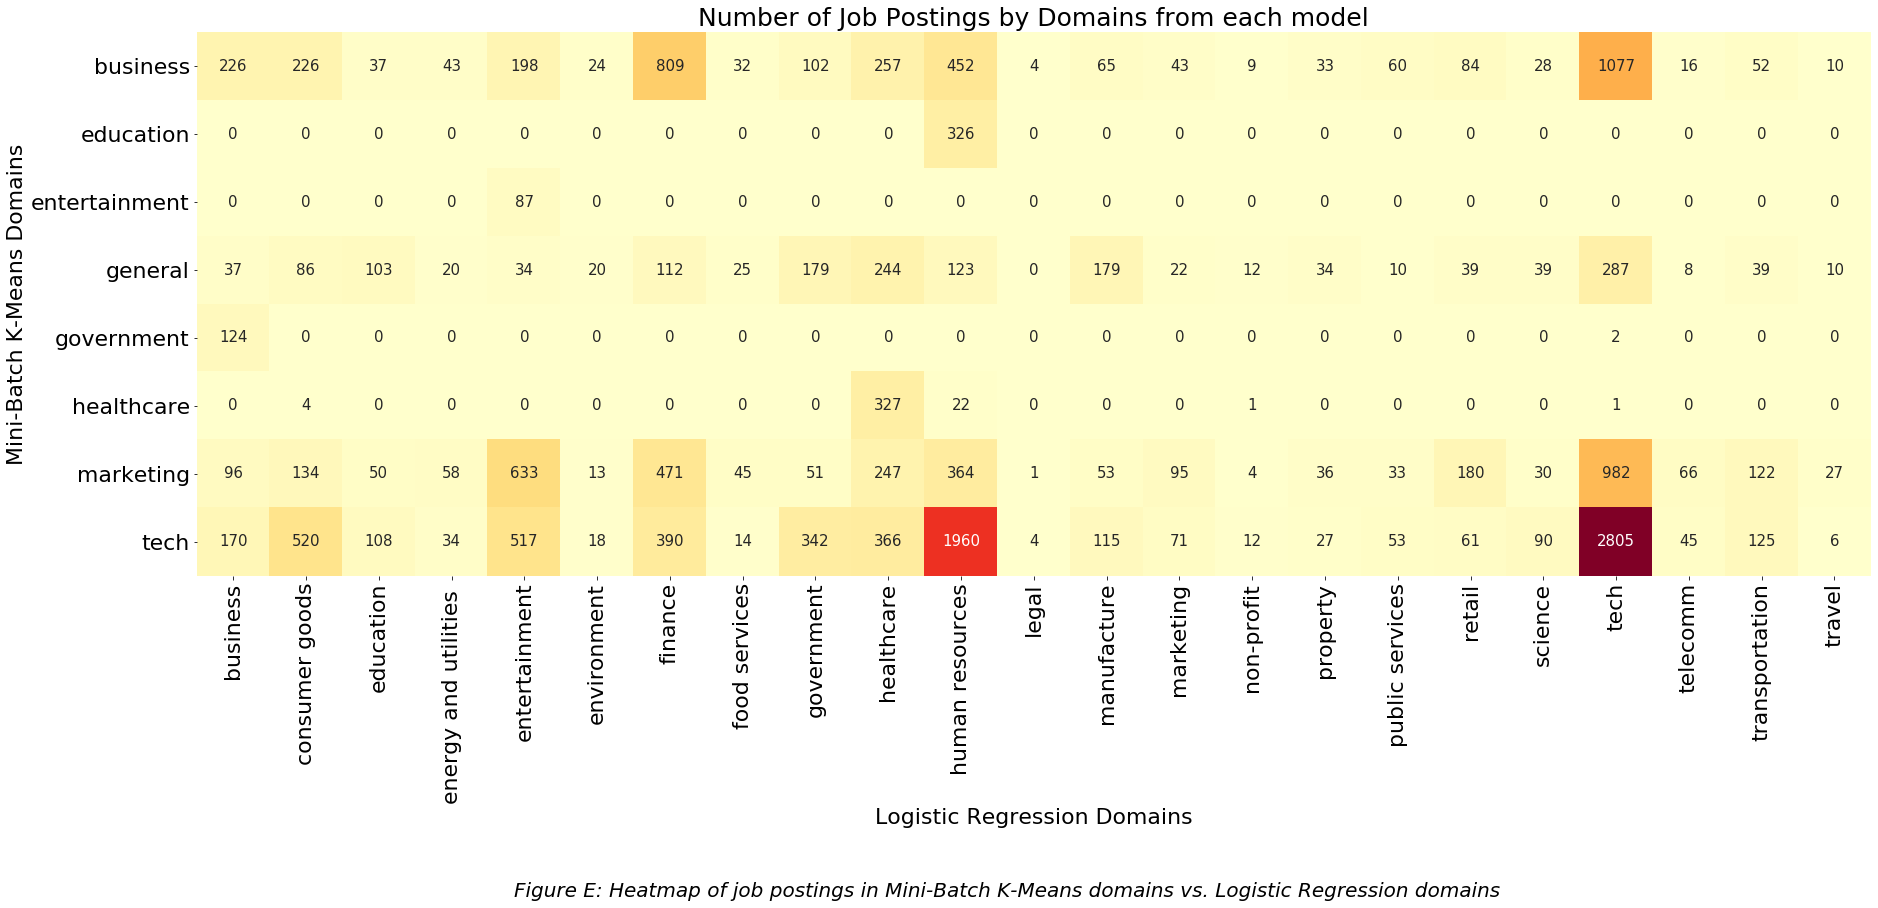

In [5]:
# Let's compare the result of the clustering method with the domains predicted from our supervised learning model
# create a pivote table that count the number of jobs for each domain
pivoted_df = pd.pivot_table(job_df, index=['domain_minik'],
                    columns=['domain_lr'], values=['job_description'], aggfunc='count').fillna(0)
pivoted_df.columns = [col[1] for col in pivoted_df.columns.values] # this to remove the column index

# creating a heatmap to see what domains stand out for each cluster
fig, ax = plt.subplots(figsize=(30,10))
sns.heatmap(pivoted_df, annot=True, annot_kws={"fontsize":15}, cmap=plt.cm.YlOrRd, fmt='g', cbar=False)
plt.yticks(np.arange(0.5, len(pivoted_df.index), 1), pivoted_df.index, fontsize=22)
plt.xticks(np.arange(0.5, len(pivoted_df.columns), 1), pivoted_df.columns, rotation=90, fontsize=22)
plt.xlabel('Logistic Regression Domains', fontsize=22)
plt.ylabel('Mini-Batch K-Means Domains', fontsize=22)
plt.title("Number of Job Postings by Domains from each model", fontsize=25)

# add title to the figure so it can be easily reference in our blog post
plt.suptitle('Figure E: Heatmap of job postings in Mini-Batch K-Means domains vs. Logistic Regression domains', y=-0.3, style='italic', fontsize=20)  

plt.savefig("blog_visualizations/heatmap_domains", bbox_inches="tight", dpi=300)

plt.show()

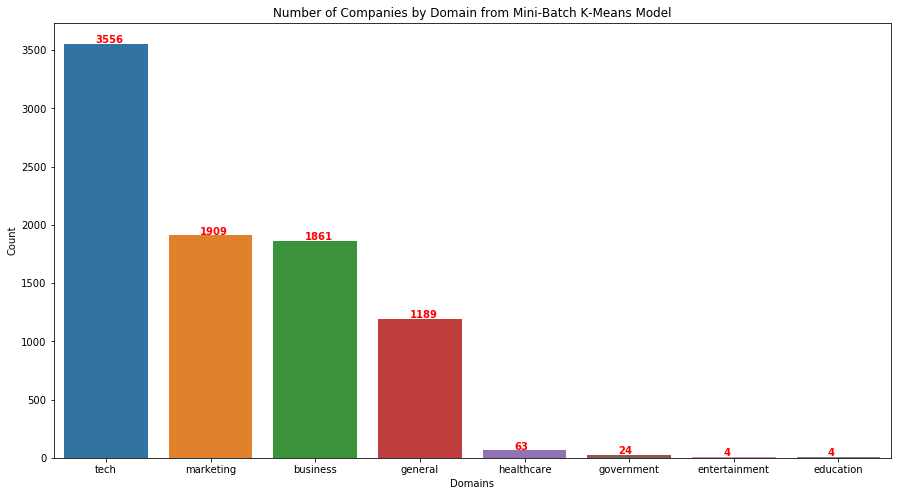

In [6]:
# let's look at the number of companies for each domain from minik model
minik_df = job_df.groupby(['domain_minik'])['company_name'].nunique().sort_values(ascending=False)
plt.figure(figsize=(15,8))
sns.barplot(x=minik_df.index, y=minik_df)

# add annotation to each bar to show the counts
for i, v in enumerate(minik_df):
    plt.text(i -.1, v + 10, str(v), color='red', fontweight='bold')

plt.title('Number of Companies by Domain from Mini-Batch K-Means Model')
plt.xlabel('Domains')
plt.ylabel('Count')
plt.show()



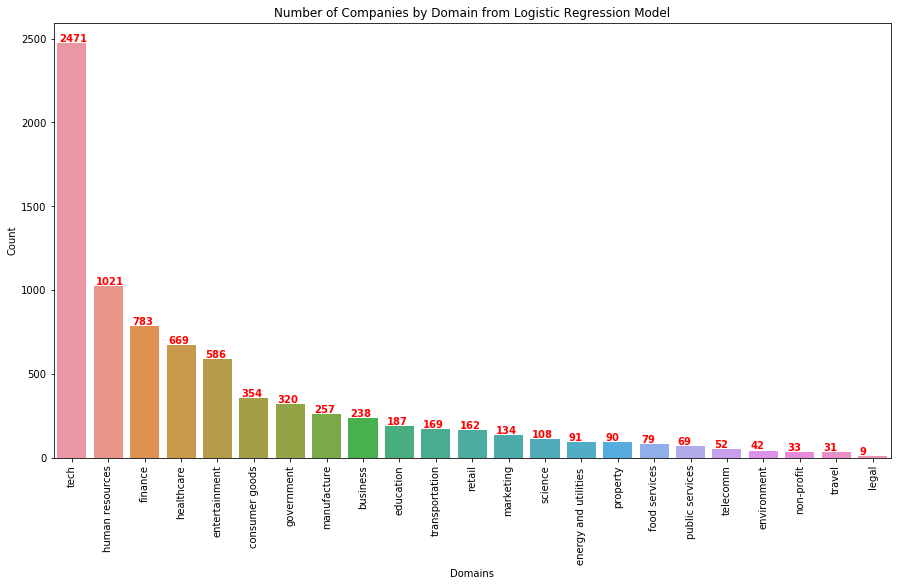

In [7]:
# let's look at the number of companies for each domain from logistic regression model
lr_df = job_df.groupby(['domain_lr'])['company_name'].nunique().sort_values(ascending=False)
plt.figure(figsize=(15,8))
sns.barplot(x=lr_df.index, y=lr_df)

# add annotation to each bar to show the counts
for i, v in enumerate(lr_df):
    plt.text(i -.35, v + 10, str(v), color='red', fontweight='bold')

plt.title('Number of Companies by Domain from Logistic Regression Model')
plt.xlabel('Domains')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()